In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import json

In [3]:
from collections import defaultdict

In [4]:
import numpy as np
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    style='whitegrid', # стиль figure
    font_scale=3, # размер шрифта
    rc={
#         'lines.linewidth': 3, # ширина линий
        'text.usetex' : True # использовать tex
    } 
)

In [6]:
from visualization_utils import visualize

In [7]:
with open('data_new.pkl', 'rb') as f:
    results = pickle.load(f)

In [8]:
with open('viz_data_new.pkl', 'rb') as f:
    (X, Y) = pickle.load(f)

In [9]:
classes = defaultdict(list)
for i, y in enumerate(Y):
    tag = y.split('_')[-1][:-1]
    classes[tag].append(i)
classes

defaultdict(list,
            {'S2': [0,
              1,
              2,
              16,
              17,
              18,
              32,
              33,
              34,
              48,
              49,
              50,
              64,
              65,
              66,
              80,
              81,
              82,
              96,
              97,
              98,
              112,
              113,
              114,
              128,
              129,
              130,
              144,
              145,
              146,
              160,
              161,
              162,
              176,
              177,
              178,
              192,
              193,
              194,
              208,
              209,
              210,
              224,
              225,
              226,
              240,
              241,
              242],
             'C2': [3,
              4,
              5,
              19,
            

In [10]:
func_dirs = set([r['tag'] for r in results if r['tag'][-1] in ['X', 'Y', 'Z']])
func_dirs

{'C2X',
 'C2Y',
 'C2Z',
 'L2X',
 'L2Y',
 'L2Z',
 'S2X',
 'S2Y',
 'S2Z',
 'SS2X',
 'SS2Y',
 'SS2Z'}

In [11]:
funcs = set([r['tag'][:-1] for r in results if r['tag'][-1] in ['X', 'Y', 'Z']])
funcs

{'C2', 'L2', 'S2', 'SS2'}

In [12]:
def make_data(results):
    X, X_f, Y = [], [], []
    for r in results:
        X.append(np.array(r['x']).reshape(1, -1))
        X_f.append(np.array(r['exp_data']).reshape(1, -1))
        Y.append(r['dir_name'] + ' ' + r['tag'])
    X = np.concatenate(X, axis=0)
    X_f = np.concatenate(X_f, axis=0)
    return X, X_f, Y

In [13]:
def enumerate_stacks(Y):
    unique_labels = set([y.split(' ')[0] for y in Y])
    labels_map = {item: i + 1  for i, item in enumerate(sorted(unique_labels))}
    labels = []
    for y in Y:
        if ' ' not in y:
            stack, tag = y, ''
        else:
            stack, tag = y.split(' ', 1)
        labels.append('{stack} {tag}'.format(stack=labels_map[stack], tag=tag))
    return labels

In [14]:
from functools import cmp_to_key

def order_stacks(X, X_f, Y):
    def cmp(a, b):
        a = a[-1]
        b = b[-1]
        a, aa = a.split(' ', 1)
        a = int(a)
        b, bb = b.split(' ', 1)
        b = int(b)
        if (a > b) or ((a == a) and (aa > bb)):
            return 1
        elif (a == b) and (aa == bb):
            return 0
        else:
            return -1
        
    new_X, new_X_f, new_Y = [], [], []
    for x, x_f, y in sorted(zip(X, X_f, Y), key=cmp_to_key(cmp)):
#         print(x.shape)
        new_X.append(x.reshape(1, -1))
        new_X_f.append(x_f.reshape(1, -1))
        new_Y.append(y)
    return np.concatenate(new_X, axis=0), np.concatenate(new_X_f, axis=0), new_Y

## Выбираем из данных фиксированную корр функцию, и для неё берём все образцы и все направления

In [15]:
funcs = {('C2', '$C_{2}$'), 
         ('L2', '$L_{2}$'),
         ('S2', '$S_{2}$'),
         ('SS2', '$SS_{2}$')}

In [16]:
def trunc_Y(Y, dirs=True):
    if dirs:
        dirs_map = {
            'X': '$X$',
            'Y': '$Y$',
            'Z': '$Z$',
        }
    else:
        dirs_map = {
            'X': '',
            'Y': '',
            'Z': '',
        }
    new_Y = []
    for y in Y:
        y = y.replace(f, '')
        for k, v in dirs_map.items():
            y = y.replace(k, v)
        new_Y.append(y)
    return new_Y

In [17]:
funcs

{('C2', '$C_{2}$'), ('L2', '$L_{2}$'), ('S2', '$S_{2}$'), ('SS2', '$SS_{2}$')}

In [18]:
# new_Y
scalers = {}
for f, _ in funcs:
    filtered_results = [r for r in results if r['tag'].startswith(f) and (r['tag'] != f)]
    X, X_f, Y = make_data(filtered_results)
    scalers[f] = StandardScaler().fit(X)
    scalers[f + '_f'] = StandardScaler().fit(X_f)

In [34]:
categories_2 = [
    'arable',
    'post arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'post arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'arable',
    'post arable',
]
categories_3 = [
    'bare fallow',
    'afforestation',
    'cereals',
    'cereals',
    'bare fallow',
    'bare fallow',
    'bare fallow',
    'bare fallow',
    'afforestation',
    'cereals',
    'cereals',
    'cereals',
    'cereals',
    'cereals',
    'cereals',
    'afforestation'
]

In [25]:
Y

['1 $X$',
 '2 $X$',
 '4 $X$',
 '7 $X$',
 '8 $X$',
 '1 $Y$',
 '4 $Y$',
 '8 $Y$',
 '1 $Z$',
 '2 $Y$',
 '2 $Z$',
 '3 $X$',
 '3 $Y$',
 '4 $Z$',
 '5 $X$',
 '6 $X$',
 '8 $Z$',
 '9 $X$',
 '13 $X$',
 '15 $X$',
 '6 $Y$',
 '7 $Y$',
 '9 $Y$',
 '10 $X$',
 '10 $Y$',
 '13 $Y$',
 '14 $Y$',
 '15 $Y$',
 '9 $Z$',
 '14 $X$',
 '3 $Z$',
 '5 $Y$',
 '7 $Z$',
 '10 $Z$',
 '11 $X$',
 '11 $Y$',
 '11 $Z$',
 '12 $X$',
 '12 $Y$',
 '5 $Z$',
 '6 $Z$',
 '12 $Z$',
 '13 $Z$',
 '14 $Z$',
 '15 $Z$',
 '16 $X$',
 '16 $Y$',
 '16 $Z$']

In [ ]:
for f, tex in funcs:
    filtered_results = [r for r in results 
                        if r['tag'].startswith(f) 
                            and (r['tag'][-1] in ['X', 'Y', 'Z'])]
    print('Func: {}'.format(f))
    print('Tags : {}'.format(str(set([item['tag'] for item in filtered_results]))))
    X, X_f, Y = make_data(filtered_results)
    Y = enumerate_stacks(Y)
    X, X_f, Y = order_stacks(X, X_f, Y)
    Y = trunc_Y(Y)
    print('Data shapes: {}, {}'.format(X.shape, len(Y)))
    visualize(X, X_f, Y, categories=(categories_2, categories_3), scalers=scalers, exp_name=f, tex=tex, ns=[2, 3, 6, 10], fdir='vis_results', dpi=400)

## Выбираем из данных фиксированную корр функцию и направление и для неё берём все образцы

In [26]:
pairs = []
for item in func_dirs:
    pos = item.find('2')
    s = '$' + item[:pos] + '_{{ {s} }}'.format(s=item[pos:]) + '$'
    pairs.append((item, s))
pairs = set(pairs)
pairs

{('C2X', '$C_{ 2X }$'),
 ('C2Y', '$C_{ 2Y }$'),
 ('C2Z', '$C_{ 2Z }$'),
 ('L2X', '$L_{ 2X }$'),
 ('L2Y', '$L_{ 2Y }$'),
 ('L2Z', '$L_{ 2Z }$'),
 ('S2X', '$S_{ 2X }$'),
 ('S2Y', '$S_{ 2Y }$'),
 ('S2Z', '$S_{ 2Z }$'),
 ('SS2X', '$SS_{ 2X }$'),
 ('SS2Y', '$SS_{ 2Y }$'),
 ('SS2Z', '$SS_{ 2Z }$')}

In [23]:
for f, tex in pairs:
    filtered_results = [r for r in results if r['tag'].startswith(f)]
    print('Func: {}'.format(f))
    print('Tags : {}'.format(str(set([item['tag'] for item in filtered_results]))))
    X, X_f, Y = make_data(filtered_results)
    Y = enumerate_stacks(Y)
    X, X_f, Y = order_stacks(X, X_f, Y)
    Y = trunc_Y(Y, dirs=False)
    print('Data shapes: {}, {}'.format(X.shape, len(Y)))
    visualize(X, X_f, Y,
              scalers, 
              exp_name=f, 
              tex=tex, 
              ns=[2, 3, 6, 10], 
              fdir='vis_results', 
              dpi=400)

Func: S2Y
Tags : {'S2Y'}
Data shapes: (16, 6), 16
Func: C2Y
Tags : {'C2Y'}
Data shapes: (16, 6), 16
Func: C2X
Tags : {'C2X'}
Data shapes: (16, 6), 16
Func: S2Z
Tags : {'S2Z'}
Data shapes: (16, 6), 16
Func: SS2Z
Tags : {'SS2Z'}
Data shapes: (16, 6), 16
Func: SS2X
Tags : {'SS2X'}
Data shapes: (16, 6), 16
Func: S2X
Tags : {'S2X'}
Data shapes: (16, 6), 16
Func: L2Y
Tags : {'L2Y'}
Data shapes: (16, 6), 16
Func: L2X
Tags : {'L2X'}
Data shapes: (16, 6), 16
Func: SS2Y
Tags : {'SS2Y'}
Data shapes: (16, 6), 16
Func: L2Z
Tags : {'L2Z'}
Data shapes: (16, 6), 16
Func: C2Z
Tags : {'C2Z'}
Data shapes: (16, 6), 16


## Визуализируем усредненные по трём направлениям корр функции для каждого образца

In [ ]:
for f, tex in funcs:
    filtered_results = [r for r in results 
                        if r['tag'].startswith(f) 
                            and (r['tag'][-1] not in ['X', 'Y', 'Z'])]
    print('Func: {}'.format(f))
    print('Tags : {}'.format(str(set([item['tag'] for item in filtered_results]))))
    X, X_f, Y = make_data(filtered_results)
    Y = enumerate_stacks(Y)
    X, X_f, Y = order_stacks(X, X_f, Y)
    Y = trunc_Y(Y, dirs=False)
    print('Data shapes: {}, {}'.format(X.shaype, len(Y)))

    visualize(X, X_f, Y, 
              scalers,
              exp_name='{}_mean'.format(f), 
#               title='mean',
              tex=tex, 
              ns=[2, 3, 6, 10], 
              fdir='vis_results', 
              dpi=400)

Func: S2
Tags : {'S2'}
Data shapes: (16, 6), 16
Func: SS2
Tags : {'SS2'}
Data shapes: (16, 6), 16
Func: L2
Tags : {'L2'}
Data shapes: (16, 6), 16
Func: C2
Tags : {'C2'}
Data shapes: (16, 6), 16


## Вытягиваем все корр функции для каждого стека в один длинный вектор, чтобы найти "расстояние" между стеками

In [27]:
def make_func_dirs(results, scalers, use_tag=True):
    stacks = defaultdict(dict)
    order = []
        
    accepted_tags = set()
    for r in results:
        stack_name = r['dir_name']
        tag = r['tag']
        # Пропускаем усредненные по всем направлениям корр функции
        if tag[-1] in ['X', 'Y', 'Z']:
            continue
        accepted_tags.add(tag)
        stacks[stack_name][tag] = {
            'x': r['x'],
            'exp_data': r['exp_data']
        }
        order.append(tag)
    print('Accepted tags: {}'.format(str(accepted_tags)))
    order = sorted(set(order))
    X, X_f, Y = [], [], []
    for stack_name, stack in stacks.items():
        Y.append(stack_name)
        x = []
        x_f = []
        for tag in order:
            x_to = np.array(stack[tag]['x']).reshape(1, -1)
            x_f_to = np.array(stack[tag]['exp_data']).reshape(1, -1)
            if scalers is not None:
                if not use_tag:
                    tag = 'all'
                x_to = scalers[tag].transform(x_to)
                x_f_to = scalers[tag + '_f'].transform(x_f_to)
            x.append(x_to)
            x_f.append(x_f_to)
        X.append(np.concatenate(x).reshape(1, -1))
        X_f.append(np.concatenate(x_f).reshape(1, -1))
    X = np.concatenate(X, axis=0)
    X_f = np.concatenate(X_f, axis=0)
    return X, X_f, Y

In [28]:
X, X_f, Y = make_func_dirs(results, scalers=scalers)
Y = enumerate_stacks(Y)
X, X_f, Y = order_stacks(X, X_f, Y)

Accepted tags: {'SS2', 'S2', 'L2', 'C2'}


In [29]:
print('Data shapes: {}, {}'.format(X.shape, len(Y)))

Data shapes: (16, 24), 16


In [30]:
from visualization_utils import visualize

In [35]:
visualize(
    X, 
    X_f, 
    Y,
    categories=(categories_2, categories_3),
    scalers=None,
    exp_name='stacks', 
    tex='stacks',
    ns=[2, 3, 6, 10], 
    fdir='vis_results', 
    dpi=400,
    use_title=False
)

In [41]:
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd
import scipy as sp

In [28]:
from visualization_utils import plot_heatmap, plot_clusters

In [144]:
funcs

{('C2', '$C_{2}$'), ('L2', '$L_{2}$'), ('S2', '$S_{2}$'), ('SS2', '$SS_{2}$')}

In [222]:
# new_Y
scalers = {}
for f, _ in funcs:
    filtered_results = [r for r in results if r['tag'].startswith(f) and (r['tag'] != f)]
    X, X_f, Y = make_data(filtered_results)
    scalers[f] = StandardScaler().fit(X)
    scalers[f + '_f'] = StandardScaler().fit(X_f)

In [223]:
# X, X_f, Y = make_data([r for r in results if r['tag'][-1] not in ['X', 'Y', 'Z']])
# X, X_f, Y = make_data([r for r in results if r['tag'][-1] in ['X', 'Y', 'Z']])
X, X_f, Y = make_data(results)
scalers['all'] = StandardScaler().fit(X)
scalers['all_f'] = StandardScaler().fit(X_f)

In [224]:
X, X_f, Y = make_func_dirs(results, scalers=scalers, use_tag=True)
Y = enumerate_stacks(Y)
X, X_f, Y = order_stacks(X, X_f, Y)

Accepted tags: {'C2', 'L2', 'SS2', 'S2'}


In [213]:
X_f_norm[:, 2].mean()

2.0122792321330962e-16

In [207]:
# X_norm = StandardScaler().fit_transform(X)
# X_f_norm = StandardScaler().fit_transform(X_f)
# X_f_norm = X_f
# X_norm = X

In [225]:
dist_matr = pairwise_distances(X) / np.sqrt(X.shape[1])

In [218]:
dist_matr_f = pairwise_distances(X_f) / np.sqrt(X_f.shape[1])
dist_matr_r_f = sp.stats.rankdata(dist_matr_f.flatten()).reshape(X_f_norm.shape[0], X_f_norm.shape[0])
dist_matr_r_f = dist_matr_r_f / dist_matr_r_f.max()

In [227]:
(dist_matr).sum(axis=1)

array([26.76446809, 23.47945907, 15.93077005, 14.8678812 , 14.98140827,
       15.70891836, 22.46346261, 17.45126176, 13.85644382, 18.26109417,
       16.60975419, 16.05331746, 15.53619646, 16.74767328, 15.54929143,
       17.95208287])

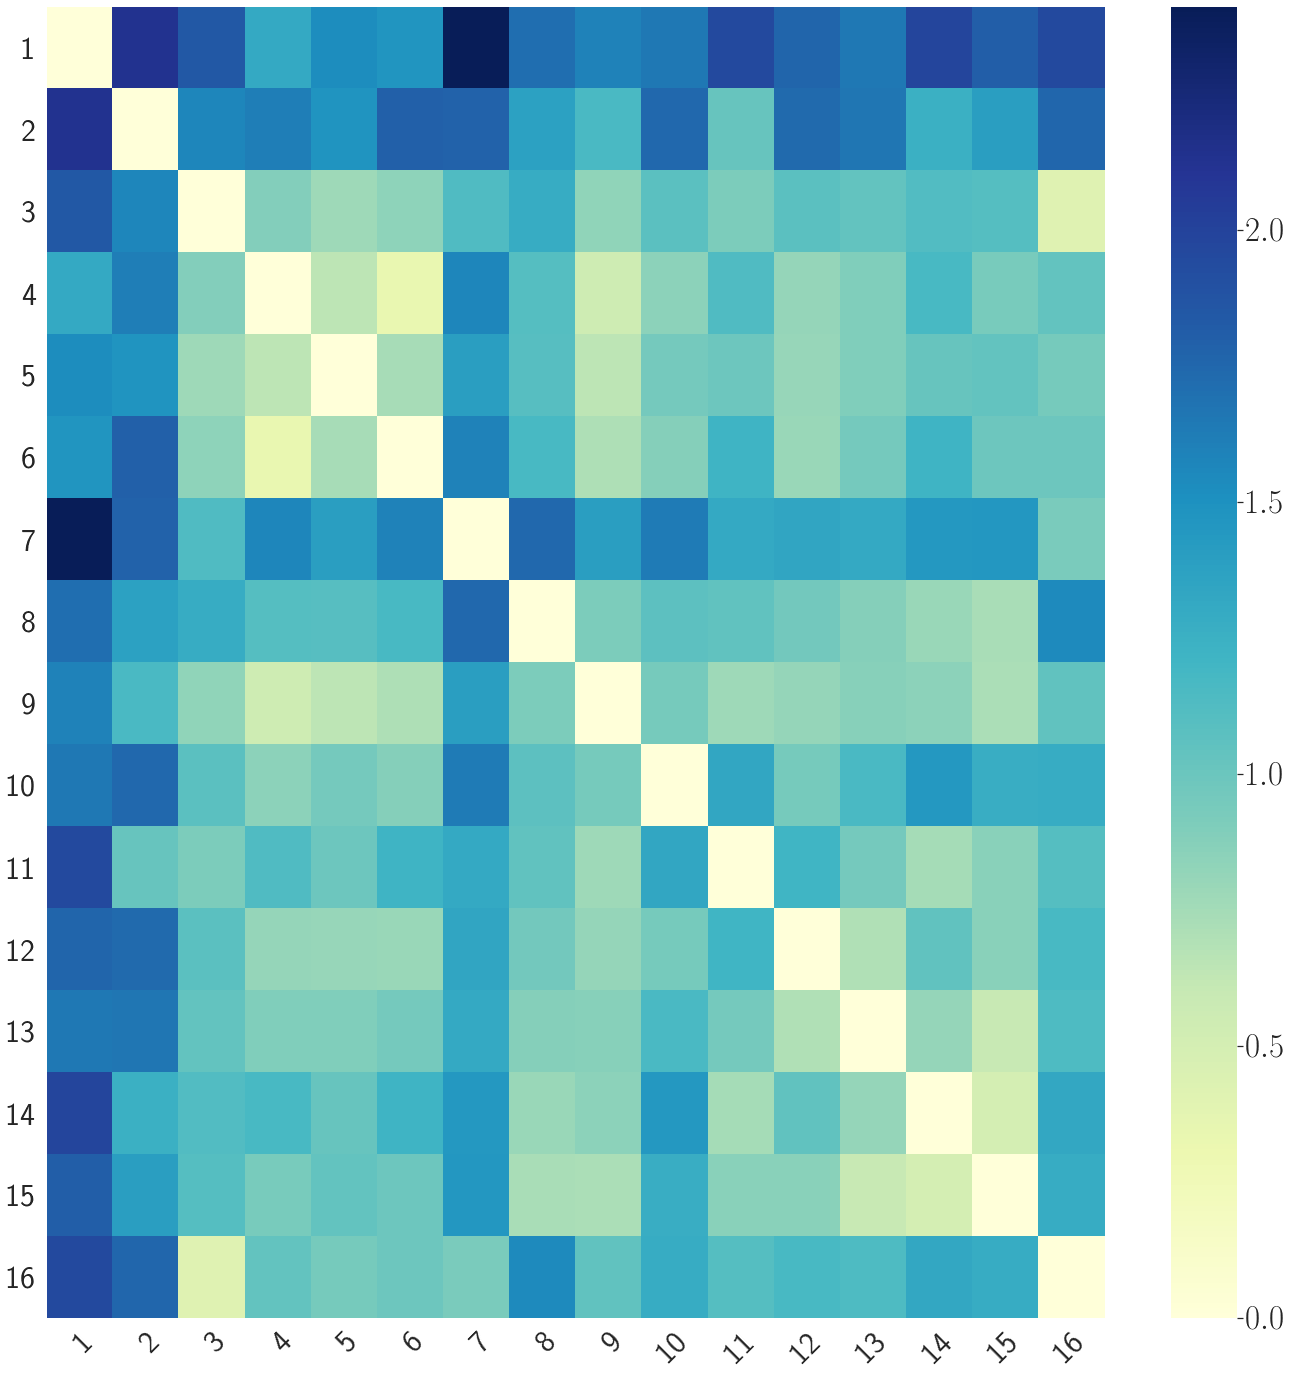

In [233]:
plot_heatmap(
    data=dist_matr,
    Y=Y,
    exp_name='stacks',
    tex='stacks',
    title='functions',
    fdir='vis_results',
    dpi=400,
    use_title=False
)

## Визуализация PCA и Kmeans для всех коррфункций и всех направлений

In [24]:
import os

In [53]:
with open('viz_data.pkl', 'rb') as f:
    (X, Y) = pickle.load(f)

In [60]:
X_normalized = StandardScaler().fit_transform(X)

In [61]:
pca = PCA(n_components=2, random_state=42)
X_embedded = pca.fit_transform(X_normalized)

In [62]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_normalized)
clusters = kmeans.predict(X_normalized)

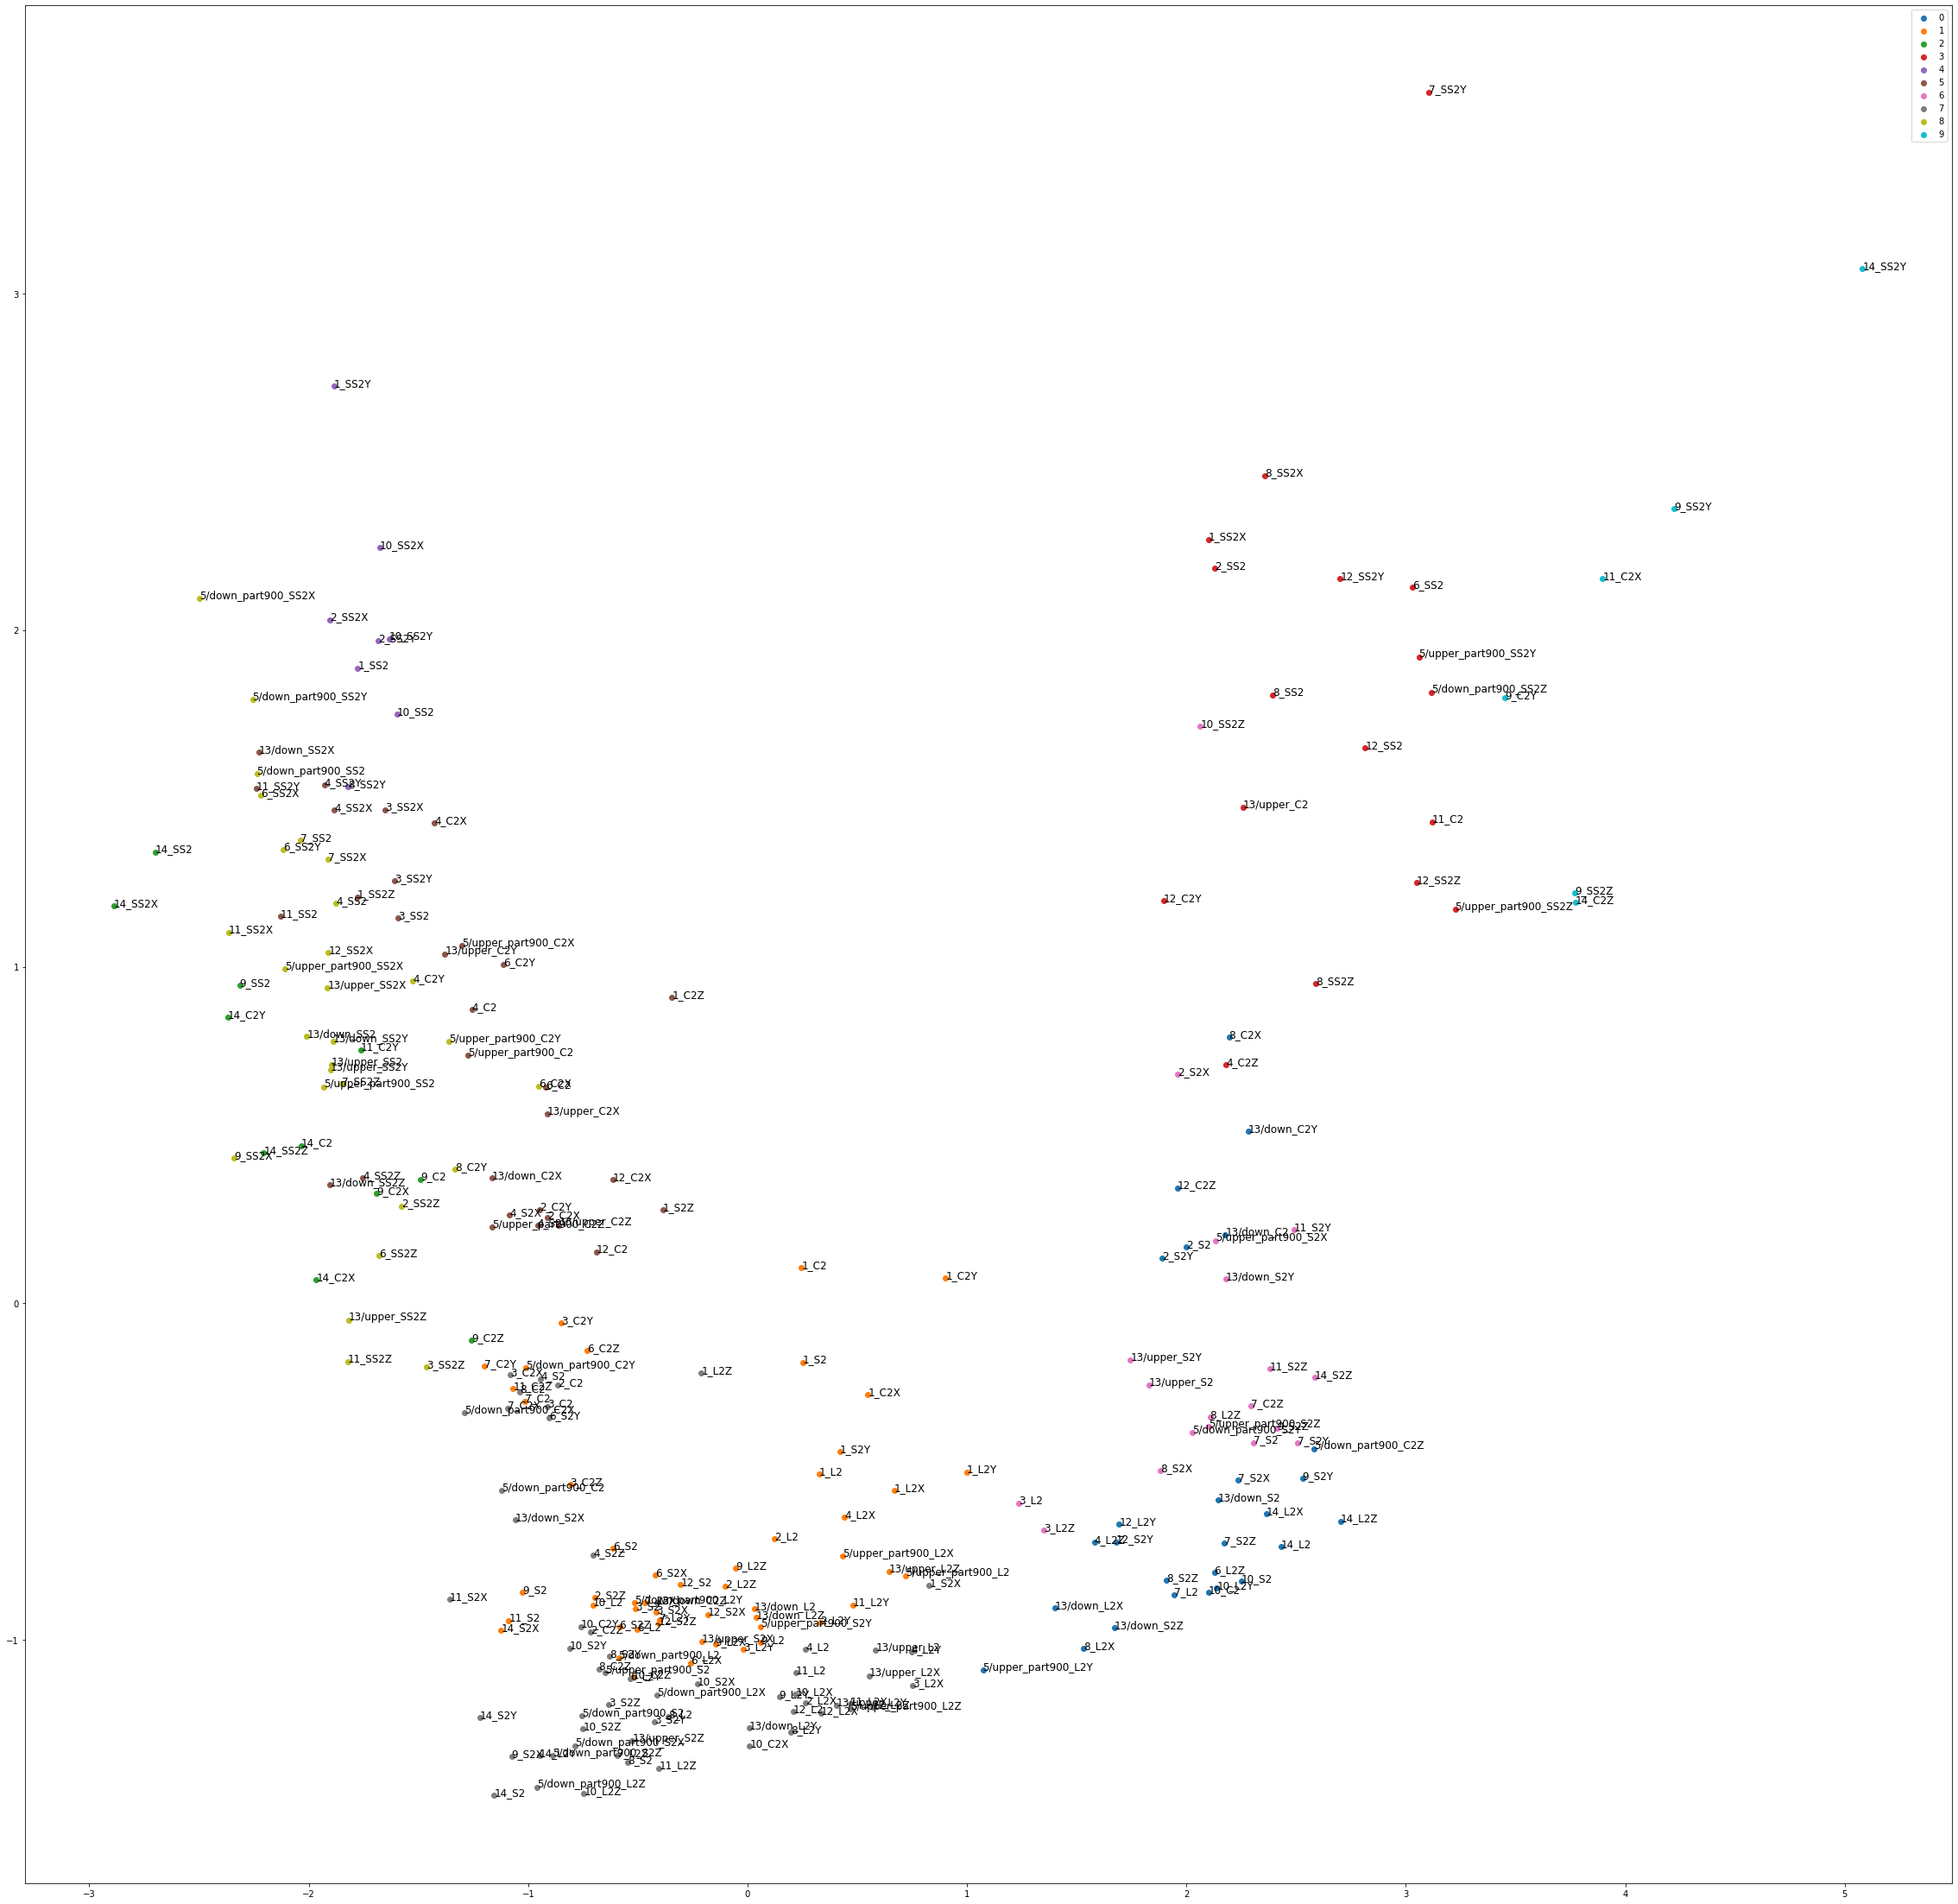

In [64]:
plt.figure(figsize=(40, 40))
for i in range(10):
    idxes,  = np.where(clusters == i)
    plt.scatter(X_embedded[idxes, 0], X_embedded[idxes, 1], label=str(i))
for i, y in enumerate(Y):
    plt.annotate(y, (X_embedded[i, 0], X_embedded[i, 1]), fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join('vis_results', 'clustering.png'))
plt.show()

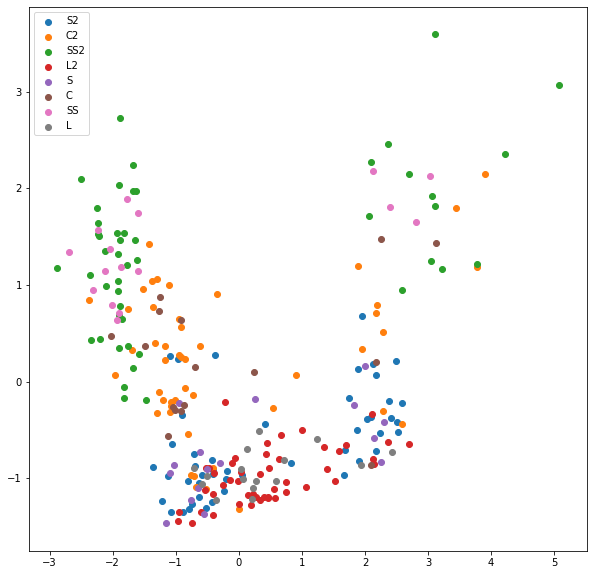

In [65]:
plt.figure(figsize=(10, 10))
for cls, idxes in classes.items():
    plt.scatter(X_embedded[idxes, 0], X_embedded[idxes, 1], label=cls)
plt.legend(loc='best')
plt.savefig(os.path.join('vis_results', 'func_small.png'))
plt.show()

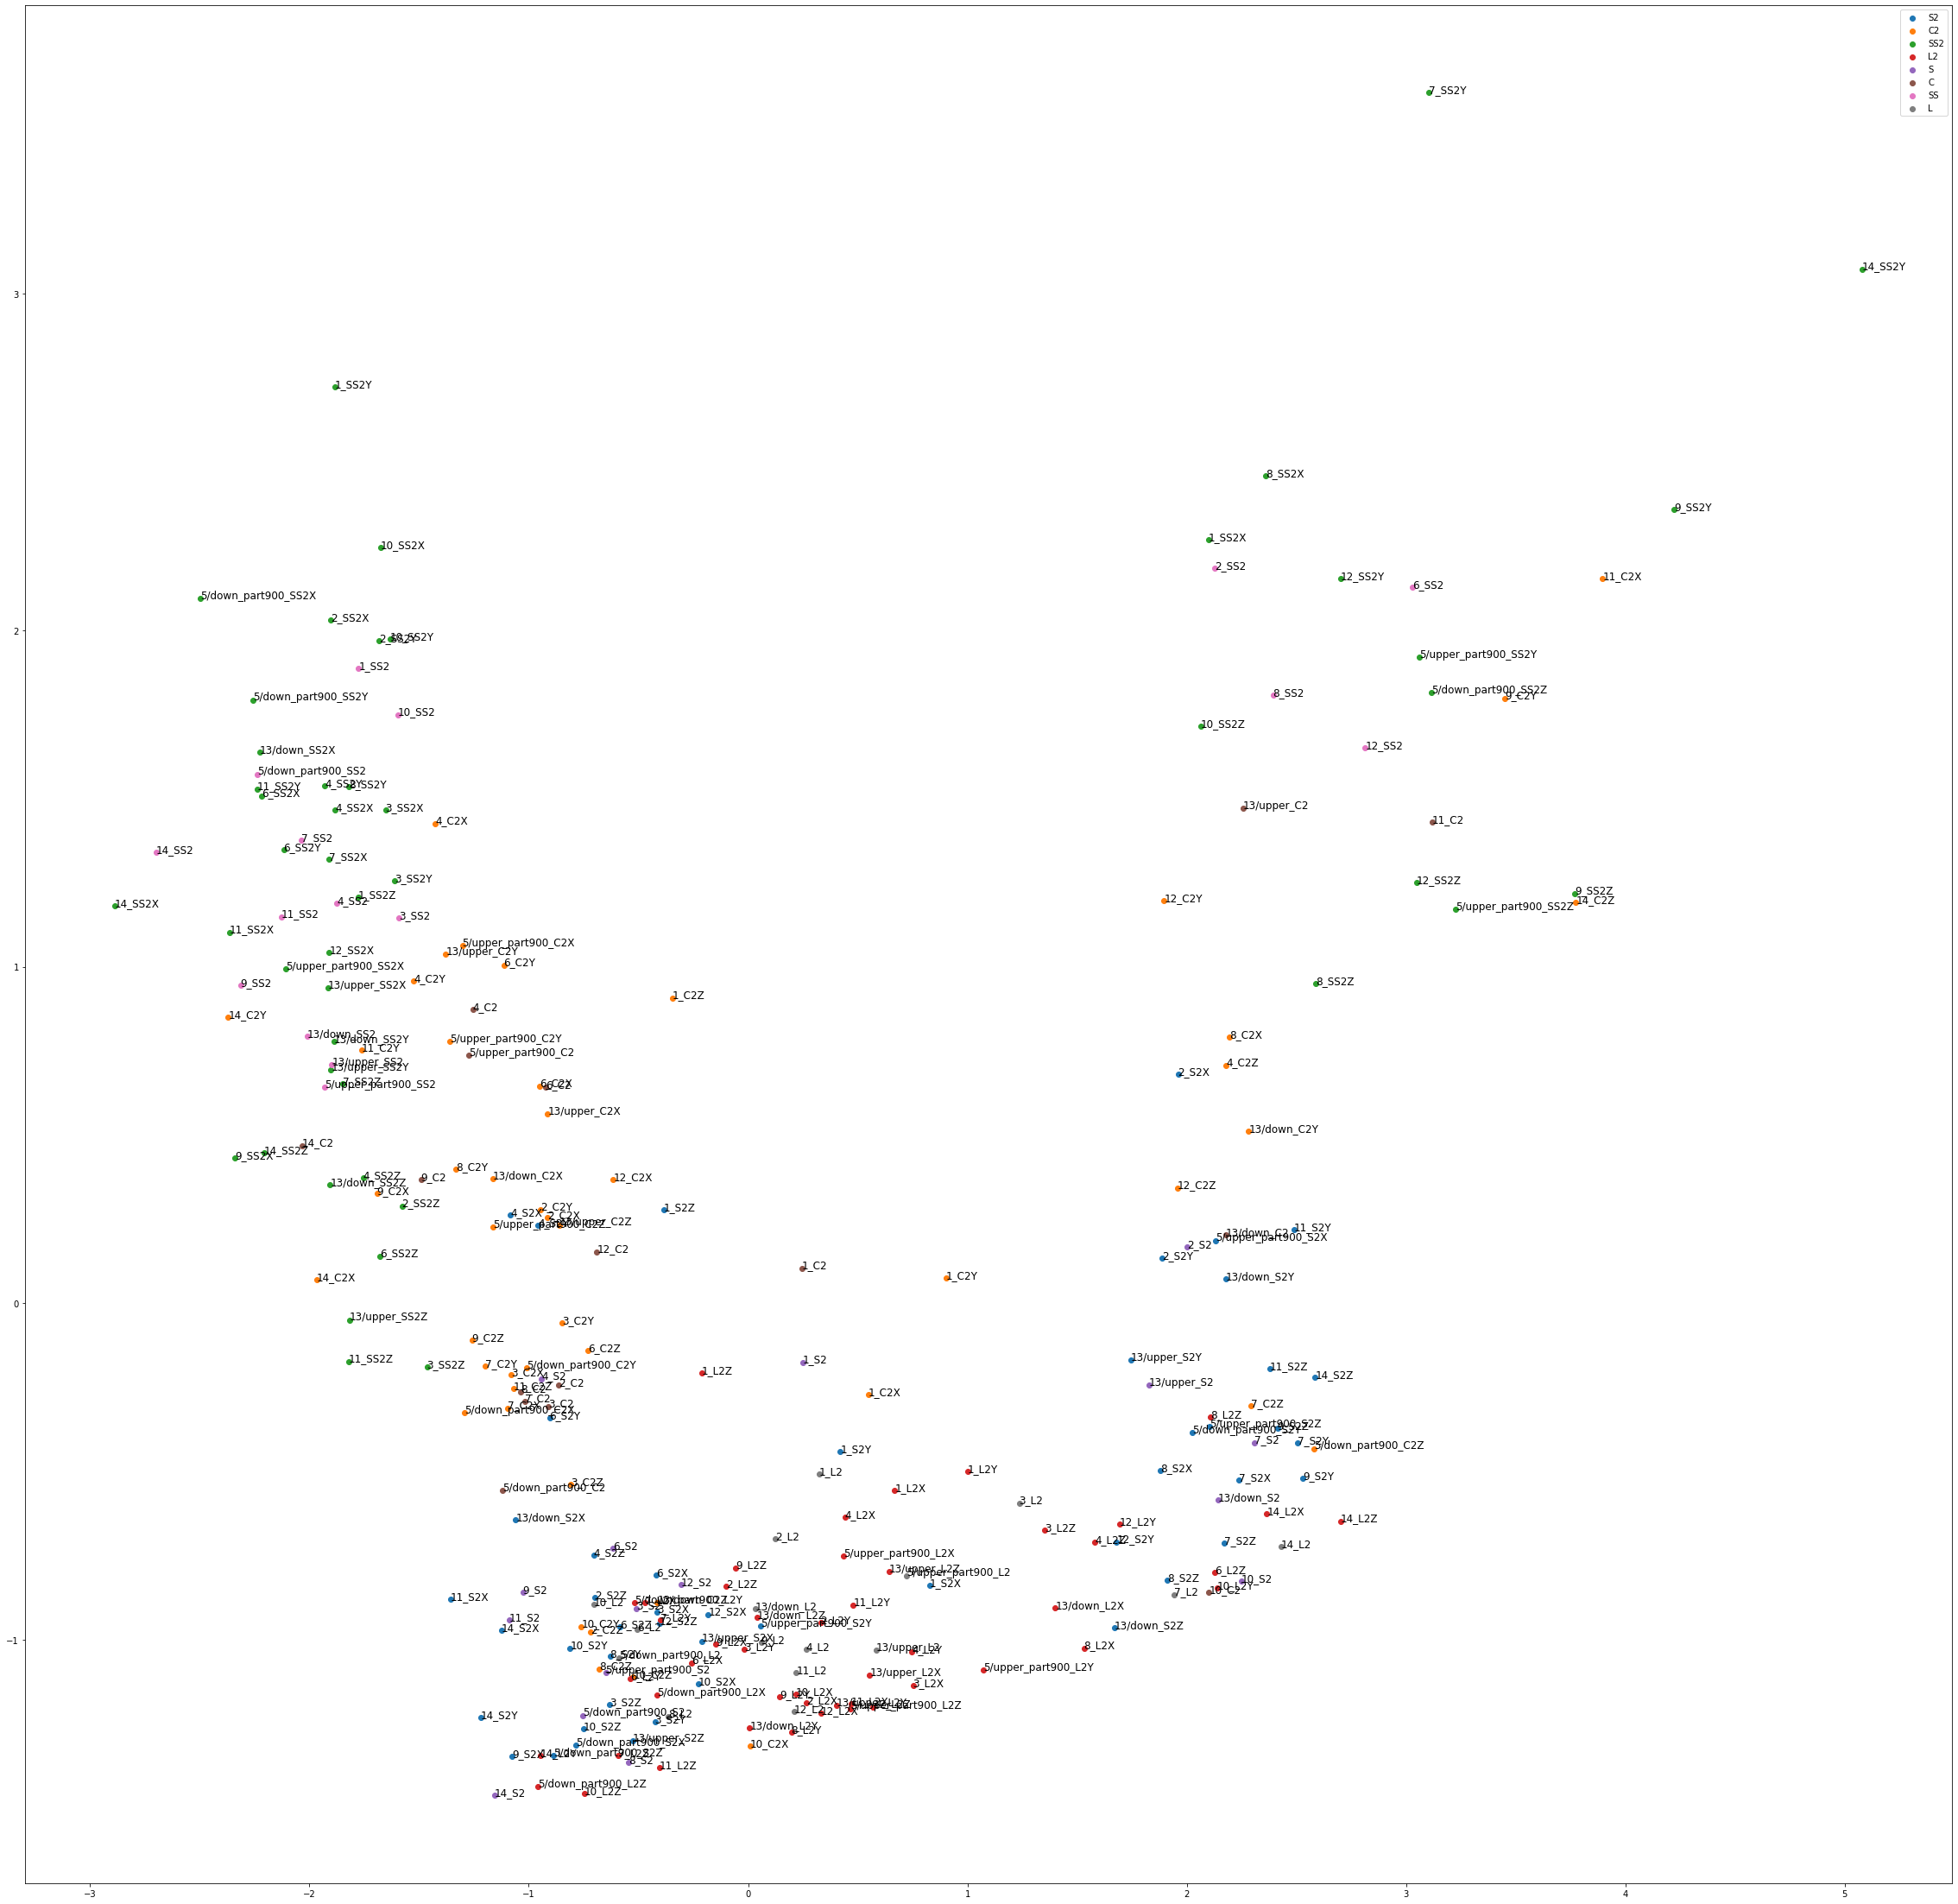

In [66]:
plt.figure(figsize=(40, 40))
for cls, idxes in classes.items():
    plt.scatter(X_embedded[idxes, 0], X_embedded[idxes, 1], label=cls)
for i, y in enumerate(Y):
    plt.annotate(y, (X_embedded[i, 0], X_embedded[i, 1]), fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join('vis_results', 'func.png'))
plt.show()